<a href="https://colab.research.google.com/github/antounes/practical-timeseries-analysis/blob/main/ch04/code/ch04_simulating_time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Time Series Data

Simulations are a way of verifying posited hypotheses about a phenomenon, looking at what can be happening in the future, or validate a model.
This post launches a series of research on time series. I belive that there is still a lot to be discovered in the field of time series. My interests concern mainly forecasting, but I'll also work on analysis and generation of time series data.

## Simulations versus forecasting

Simulation and forecasting are similar exercises. In both cases you must form hypotheses about underlying system dynamics and parameters, and then extrapolate from these hypotheses to generate data points.

Nonetheless, there are important differences to keep in mind when learning about and developing simulations rather than forecasts:
- It can be easier to integrate qualitative observations into a simulation than into a forecast
- Simulations are run at scale so that you can see many alternative scenarios (thousands or more), whereas forecasts should be more carefully produced
- Simulations have lower stakes than forecasts; there are no lives and no resources on the line, so you can be more creative and exploratory in your initial rounds of simulations. Of course, you eventually want to make sure you can justify how you build your simulations, juste as you must justify your forecasts.

## Membership and donations

Simulating a synthetic data set to test our hypotheses about how members of an organisation may (or may not) have correlated behaviour between receptiveness to organisational email and willingness to make donations. This is the most DIY example in that we hardcode relationships and generate tabular data with `for` loops and the like.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Membership status

years = [str(y) for y in range(2014, 2019)]
memberStatus = ['bronze', 'silver', 'gold', 'inactive']

memberYears = np.random.choice(years, 1000, p = [0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000, p = [0.5, 0.3, 0.1, 0.1]) # status independent from year joined

yearJoined = pd.DataFrame({'yearJoined': memberYears,
                           'memberStats': memberStats})

In [3]:
NUM_EMAILS_SENT_WEEKLY = 3 # organisation sends 3 emails each week

# Define functions for different patterns of member behaviour with respect to email
def never_opens(period_rng): # members who never open the emails
  return []

def constant_open_rate(period_rng): # members who open about the same number of emails each week
  n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
  num_opened = np.random.binomial(n, p, len(period_rng))
  return num_opened

def increasing_open_rate(period_rng): # members who open an increasing number of emails each week
  return open_rate_with_factor_change(period_rng,
                                      np.random.uniform(1.01, 1.3))

def decreasing_open_rate(period_rng): # members who open a decreasing number of emails
  return open_rate_with_factor_change(period_rng,
                                      np.random.uniform(0.5, 0.99))
  
def open_rate_with_factor_change(period_rng, fac): 
  if len(period_rng) < 1:
    return []
  times = np.random.randint(0, len(period_rng), int(0.1*len(period_rng)))
  num_opened = np.zeros(len(period_rng))
  for prd in range(0, len(period_rng), 2):
    try:
      n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
      num_opened[prd:(prd+2)] = np.random.binomial(n, p, 2)
      p = max(min(1, p*fac), 0)
    except:
      num_opened[prd] = np.random.binomial(n, p, 1)
  for t in range(len(times)):
    num_opened[times[t]] = 0
  return num_opened

In [4]:
# Donation behaviour
def produce_donations(period_rng, member_behavior, num_emails, use_id, member_join_year):
  donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 
                               1000, 1500, 2000])
  member_has = np.random.choice(donation_amounts)
  email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
  member_gives = member_has * email_fraction
  member_gives_idx = np.where(
      member_gives>=donation_amounts)[0][-1]
  member_gives_idx = max(
      min(member_gives_idx, len(donation_amounts)-2),
      1)
  num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
  times = np.random.randint(0, len(period_rng), num_times_gave)
  dons = pd.DataFrame({
      'member': [],
      'amount': [],
      'timestamp': []
  })

  for n in range(num_times_gave):
    donation = donation_amounts[member_gives_idx+np.random.binomial(1, .3)]
    ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
    dons = dons.append(pd.DataFrame({
        'member': [use_id],
        'amount': [donation],
        'timestamp': [ts]}))
    
  if dons.shape[0] > 0:
    dons = dons[dons.amount!=0]

  return dons

In [7]:
# Utility function to pick a random time during the week
def random_weekly_time_delta():
  days_of_week = [d for d in range(7)]
  hours_of_day = [h for h in range(11, 23)]
  minute_of_hour = [m for m in range(60)]
  second_of_minute = [s for s in range(60)]

  return pd.Timedelta(str(np.random.choice(days_of_week))+' days') 
  + pd.Timedelta(str(np.random.choice(hours_of_day)+' hours')) 
  + pd.Timedelta(str(np.random.choice(minute_of_hour))+' minutes') 
  + pd.Timedelta(str(np.random.choice(second_of_minute))+' seconds')

In [12]:
# Simulate a certain number of members and associated events
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])

rng = pd.period_range('2015-02-14', '2018-06-01', freq='W')
emails = pd.DataFrame({'member': [],
                       'week': [],
                       'emailsOpened': []})
donations = pd.DataFrame({'member': [],
                          'amount': [],
                          'timestamp': []})

for idx in range(yearJoined.shape[0]):
  # randomly generate the date when a member would have joined
  join_date = pd.Timestamp(yearJoined.iloc[idx]['yearJoined']) + pd.Timedelta(str(np.random.randint(0, 365))+' days')
  join_date = min(join_date, pd.Timestamp('2018-06-01'))

  # member should not have action timestamps befoire joining
  member_rng = rng[rng.start_time>join_date]

  if len(member_rng) <  1:
    continue
  
  info = member_behaviors[idx](member_rng)
  if len(info) == len(member_rng):
    emails = emails.append(pd.DataFrame(
        {'member': [idx]*len(info),
         'week': [str(r.start_time) for r in member_rng],
         'emailsOpened': info}))
    donations = donations.append(
        produce_donations(member_rng, member_behaviors[idx], sum(info), idx, join_date.year))

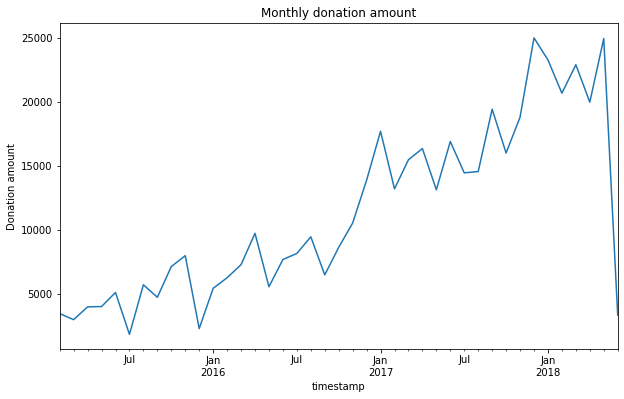

In [21]:
# Plot the total amount of donations received for each month of the data set
plt.figure(figsize=(10, 6))

donations.set_index(pd.to_datetime(donations['timestamp']), inplace=True)
donations.sort_index(inplace=True)
plt.xlabel('Date');
plt.ylabel('Donation amount');
plt.title('Monthly donation amount')
donations.groupby(pd.Grouper(freq='M'))['amount'].sum().plot();

## Building a Simulation Universe That Runs Itself

Simulating the synthetic data set to explore aggregate behaviour in a fleet of taxis, complete with shift times and time-of-day-dependent frequency of passengers. In this data set, we make use of Python's object-oriented attributes as well as generators, which are quite helpful when we want to set a system going and see what it does.

In [48]:
import numpy as np
import queue

In [34]:
def taxi_id_number(num_taxis):
  arr = np.arange(num_taxis)
  np.random.shuffle(arr)
  for i in range(num_taxis):
    yield arr[i]

In [44]:
ids = taxi_id_number(10)
print(next(ids))
print(next(ids))
print(next(ids))

4
1
0


In [45]:
# Compartimentalise taxis into different shifts
def shift_info():
  start_times_and_freqs = [(0, 8), (8, 30), (16, 15)]
  indices = np.arange(len(start_times_and_freqs))
  while True:
    idx = np.random.choice(indices, p=[0.25, 0.5, 0.25])
    start = start_times_and_freqs[idx]
    yield (start[0], start[0]+7.5, start[1])

In [46]:
# Establish individual taxi parameters
def taxi_process(taxi_id_generator, shift_info_generator):
  taxi_id = next(taxi_id_generator)
  shift_start, shift_end, shift_mean_trips = next(shift_info_generator)
  actual_trips = round(np.random.normal(
      loc=shift_mean_trips, scale=2))
  average_trip_time = 6.5 / shift_mean_trips * 60 # convert mean trip time to minutes
  between_events_time = 1.0 / (shift_mean_trips - 1) * 60 # this is an efficient city where cabs are seldom unusued
  time = shift_start
  yield TimePoint(taxi_id, 'start shift', time)
  deltaT = np.random.poisson(between_events_time) / 60
  time += deltaT
  for i in range(actual_trips):
    yield TimePoint(taxi_id, 'pick up', time)
    deltaT = np.random.poisson(average_trip_time) / 60
    time += deltaT
    yield TimePoint(taxi_id, 'drop off', time)
    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
  deltaT = np.random.poisson(between_events_time) / 60
  time += deltaT
  yield TimePoint(taxi_id, 'end shift', time)

In [47]:
# taxi_process geenrator yields TimePoint objects, which are defined as follows
from dataclasses import dataclass

@dataclass
class TimePoint:
  taxi_id: int
  name: str
  time: float

  def __lt__(self, other):
    return self.time < other.time

In [49]:
# Simulation class
class Simulator:
  def __init__(self, num_taxis):
    self._time_points = queue.PriorityQueue()
    taxi_id_generator = taxi_id_number(num_taxis)
    shift_info_generator = shift_info()
    self._taxis = [taxi_process(taxi_id_generator, shift_info_generator) for i in range(num_taxis)]
    self._prepare_run()

  def _prepare_run(self):
    for t in self._taxis:
      while True:
        try:
          e = next(t)
          self._time_points.put(e)
        except:
          break
  
  def run(self):
    sim_time = 0
    while sim_time < 24:
      if self._time_points.empty():
        break
      p = self._time_points.get()
      sim_time = p.time
      print(p)

In [51]:
# Run the simulation
sim = Simulator(1000)
sim.run()

Streaming output truncated to the last 5000 lines.
TimePoint(taxi_id=92, name='drop off', time=18.650000000000002)
TimePoint(taxi_id=727, name='drop off', time=18.650000000000002)
TimePoint(taxi_id=469, name='drop off', time=18.650000000000002)
TimePoint(taxi_id=889, name='pick up', time=18.650000000000002)
TimePoint(taxi_id=615, name='pick up', time=18.650000000000002)
TimePoint(taxi_id=21, name='pick up', time=18.650000000000002)
TimePoint(taxi_id=709, name='pick up', time=18.650000000000002)
TimePoint(taxi_id=97, name='drop off', time=18.650000000000002)
TimePoint(taxi_id=780, name='pick up', time=18.650000000000002)
TimePoint(taxi_id=306, name='drop off', time=18.650000000000002)
TimePoint(taxi_id=739, name='drop off', time=18.650000000000002)
TimePoint(taxi_id=313, name='pick up', time=18.650000000000006)
TimePoint(taxi_id=839, name='pick up', time=18.666666666666664)
TimePoint(taxi_id=893, name='drop off', time=18.666666666666668)
TimePoint(taxi_id=469, name='pick up', time=18.66